In [1]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import pyplot as plt
from pgfkernel import PGFKernel

%matplotlib inline
%load_ext autoreload
%autoreload 2

/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Generating Data

In [3]:
train_theta = torch.linspace(0, 2 * math.pi, 101)
train_theta = train_theta[:-1]
train_x1 = torch.cos(train_theta)
train_x2 = torch.sin(train_theta)
train_x = torch.stack((train_x1, train_x2), 1)
test_y = torch.mul(torch.add(torch.pow(torch.cos(train_theta),2),1),0.5)


In [4]:
curr_dir = os.getcwd()
if os.path.exists(os.path.join(curr_dir, 'train_y.pt')):
    train_y = torch.load('train_y.pt')
else:
    train_y = torch.mul(torch.add(torch.pow(torch.cos(train_theta),2),1),0.5) + torch.randn(train_theta.size()) * math.sqrt(0.01)
    torch.save(train_y, 'train_y.pt')

## Visualising Data

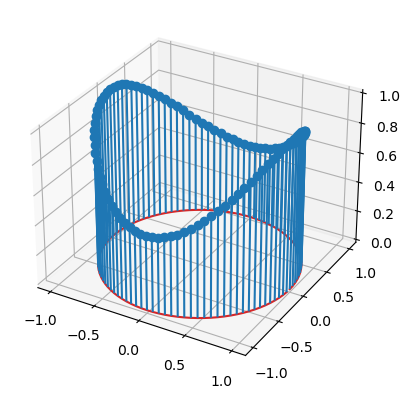

In [5]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(train_x1.numpy(), train_x2.numpy(), test_y.numpy())
plt.show()

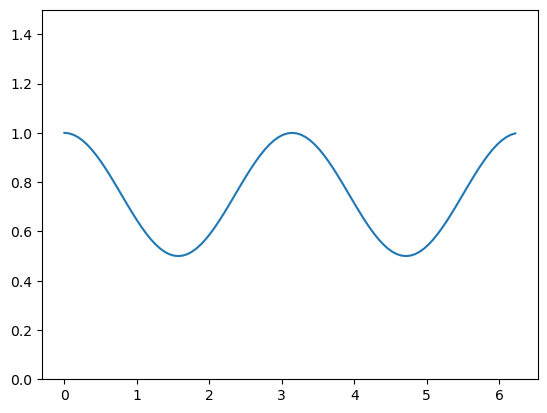

In [6]:
plt.plot(train_theta, test_y)
plt.ylim(0, 1.5)
plt.show()

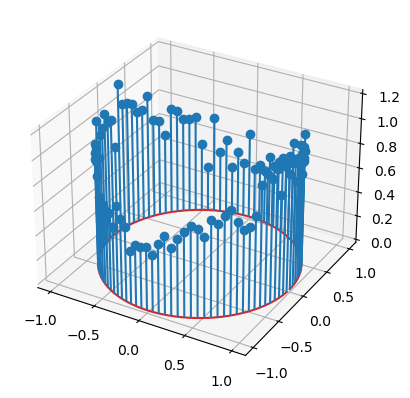

In [7]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(train_x1.numpy(), train_x2.numpy(), train_y.numpy())
plt.show()

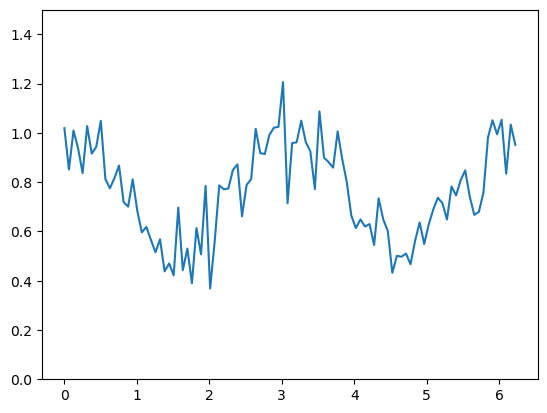

In [8]:
plt.plot(train_theta, train_y)
plt.ylim(0, 1.5)
plt.show()

# Training Model

## Varying Depth

### 1-Depth Model

In [9]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = PGFKernel(width=[3])
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [10]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.829   noise: 0.693
Iter 2/50 - Loss: 0.793   noise: 0.644
Iter 3/50 - Loss: 0.757   noise: 0.598
Iter 4/50 - Loss: 0.720   noise: 0.554
Iter 5/50 - Loss: 0.683   noise: 0.513
Iter 6/50 - Loss: 0.646   noise: 0.474
Iter 7/50 - Loss: 0.608   noise: 0.437
Iter 8/50 - Loss: 0.569   noise: 0.403
Iter 9/50 - Loss: 0.530   noise: 0.370
Iter 10/50 - Loss: 0.491   noise: 0.340
Iter 11/50 - Loss: 0.451   noise: 0.312
Iter 12/50 - Loss: 0.411   noise: 0.286
Iter 13/50 - Loss: 0.370   noise: 0.261
Iter 14/50 - Loss: 0.329   noise: 0.239
Iter 15/50 - Loss: 0.288   noise: 0.218
Iter 16/50 - Loss: 0.246   noise: 0.199
Iter 17/50 - Loss: 0.204   noise: 0.181
Iter 18/50 - Loss: 0.161   noise: 0.165
Iter 19/50 - Loss: 0.119   noise: 0.150
Iter 20/50 - Loss: 0.076   noise: 0.136
Iter 21/50 - Loss: 0.034   noise: 0.124
Iter 22/50 - Loss: -0.009   noise: 0.112
Iter 23/50 - Loss: -0.051   noise: 0.102
Iter 24/50 - Loss: -0.093   noise: 0.092
Iter 25/50 - Loss: -0.135   noise: 0.084
Iter 

In [11]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

/opt/miniconda3/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


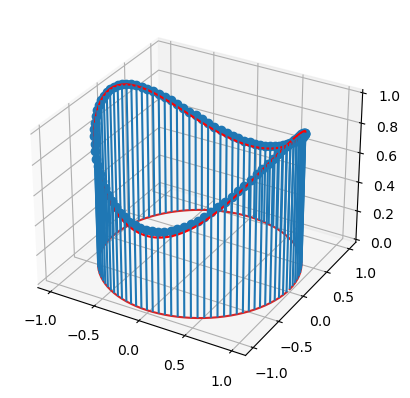

In [12]:
observed_y = observed_pred.mean
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(train_x1.numpy(), train_x2.numpy(), observed_y.numpy())
ax.plot(train_x1.numpy(), train_x2.numpy(), test_y.numpy(), color='red')
plt.show()

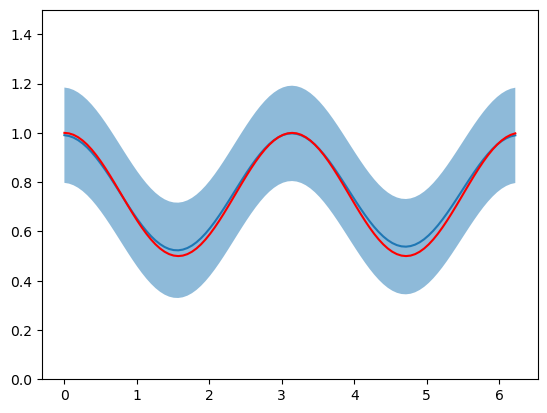

In [13]:
plt.plot(train_theta, observed_y)
plt.plot(train_theta, test_y, color='red')
lower, upper = observed_pred.confidence_region()
plt.fill_between(train_theta.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.ylim(0, 1.5)
plt.show()

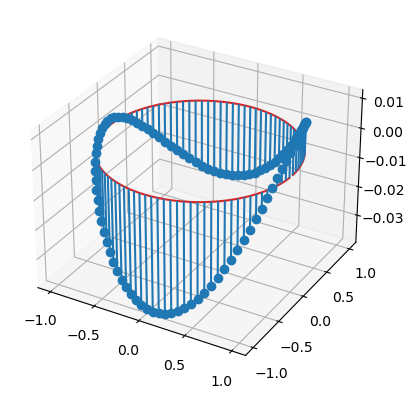

In [14]:
diff_y = test_y - observed_y
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(train_x1.numpy(), train_x2.numpy(), diff_y.numpy())
plt.show()

In [15]:
nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
msll = gpytorch.metrics.mean_standardized_log_loss(observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Standardized Log Loss: {msll:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: -1.4135, 
Mean Standardized Log Loss: -1.3969, 
Mean Squared Error: 0.0004, 
Mean Absolute Error: 0.0155


In [16]:
pgf_y = observed_y

### 2-Depth Model

In [17]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = PGFKernel(width=[3,3])
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [18]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.835   noise: 0.693
Iter 2/50 - Loss: 0.800   noise: 0.644
Iter 3/50 - Loss: 0.765   noise: 0.598
Iter 4/50 - Loss: 0.729   noise: 0.554
Iter 5/50 - Loss: 0.693   noise: 0.513
Iter 6/50 - Loss: 0.656   noise: 0.474
Iter 7/50 - Loss: 0.619   noise: 0.437
Iter 8/50 - Loss: 0.581   noise: 0.403
Iter 9/50 - Loss: 0.543   noise: 0.370
Iter 10/50 - Loss: 0.505   noise: 0.340
Iter 11/50 - Loss: 0.466   noise: 0.312
Iter 12/50 - Loss: 0.427   noise: 0.286
Iter 13/50 - Loss: 0.387   noise: 0.262
Iter 14/50 - Loss: 0.347   noise: 0.239
Iter 15/50 - Loss: 0.307   noise: 0.218
Iter 16/50 - Loss: 0.266   noise: 0.199
Iter 17/50 - Loss: 0.225   noise: 0.181
Iter 18/50 - Loss: 0.184   noise: 0.165
Iter 19/50 - Loss: 0.143   noise: 0.150
Iter 20/50 - Loss: 0.102   noise: 0.136
Iter 21/50 - Loss: 0.061   noise: 0.124
Iter 22/50 - Loss: 0.019   noise: 0.112
Iter 23/50 - Loss: -0.021   noise: 0.102
Iter 24/50 - Loss: -0.062   noise: 0.093
Iter 25/50 - Loss: -0.102   noise: 0.084
Iter 2

In [19]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

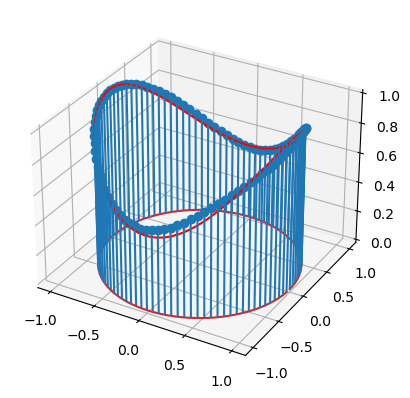

In [20]:
observed_y = observed_pred.mean
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(train_x1.numpy(), train_x2.numpy(), observed_y.numpy())
ax.plot(train_x1.numpy(), train_x2.numpy(), test_y.numpy(), color='red')
plt.show()

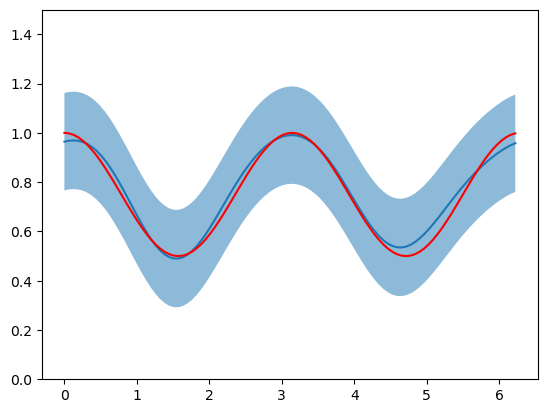

In [21]:
plt.plot(train_theta, observed_y)
plt.plot(train_theta, test_y, color='red')
lower, upper = observed_pred.confidence_region()
plt.fill_between(train_theta.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.ylim(0, 1.5)
plt.show()

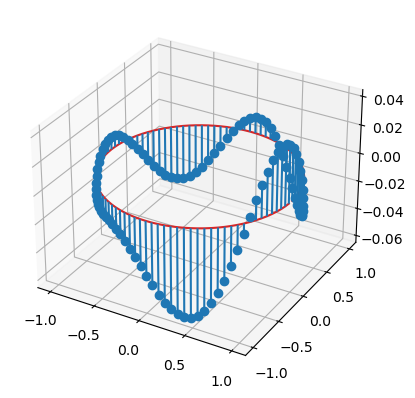

In [22]:
diff_y = test_y - observed_y
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(train_x1.numpy(), train_x2.numpy(), diff_y.numpy())
plt.show()

In [23]:
nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
msll = gpytorch.metrics.mean_standardized_log_loss(observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Standardized Log Loss: {msll:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: -1.3852, 
Mean Standardized Log Loss: -1.3554, 
Mean Squared Error: 0.0008, 
Mean Absolute Error: 0.0225


### 3-Depth Model

In [24]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = PGFKernel(width=[3,3,3])
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [25]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.836   noise: 0.693
Iter 2/50 - Loss: 0.801   noise: 0.644
Iter 3/50 - Loss: 0.766   noise: 0.598
Iter 4/50 - Loss: 0.730   noise: 0.554
Iter 5/50 - Loss: 0.695   noise: 0.513
Iter 6/50 - Loss: 0.658   noise: 0.474
Iter 7/50 - Loss: 0.621   noise: 0.437
Iter 8/50 - Loss: 0.584   noise: 0.403
Iter 9/50 - Loss: 0.546   noise: 0.370
Iter 10/50 - Loss: 0.508   noise: 0.340
Iter 11/50 - Loss: 0.469   noise: 0.312
Iter 12/50 - Loss: 0.430   noise: 0.286
Iter 13/50 - Loss: 0.391   noise: 0.262
Iter 14/50 - Loss: 0.352   noise: 0.239
Iter 15/50 - Loss: 0.312   noise: 0.218
Iter 16/50 - Loss: 0.271   noise: 0.199
Iter 17/50 - Loss: 0.231   noise: 0.181
Iter 18/50 - Loss: 0.190   noise: 0.165
Iter 19/50 - Loss: 0.150   noise: 0.150
Iter 20/50 - Loss: 0.109   noise: 0.137
Iter 21/50 - Loss: 0.068   noise: 0.124
Iter 22/50 - Loss: 0.028   noise: 0.113
Iter 23/50 - Loss: -0.013   noise: 0.102
Iter 24/50 - Loss: -0.053   noise: 0.093
Iter 25/50 - Loss: -0.092   noise: 0.084
Iter 2

In [26]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

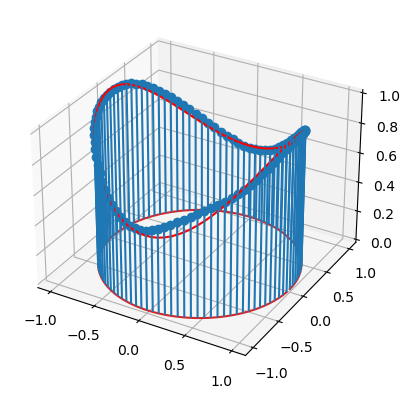

In [27]:
observed_y = observed_pred.mean
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(train_x1.numpy(), train_x2.numpy(), observed_y.numpy())
ax.plot(train_x1.numpy(), train_x2.numpy(), test_y.numpy(), color='red')
plt.show()

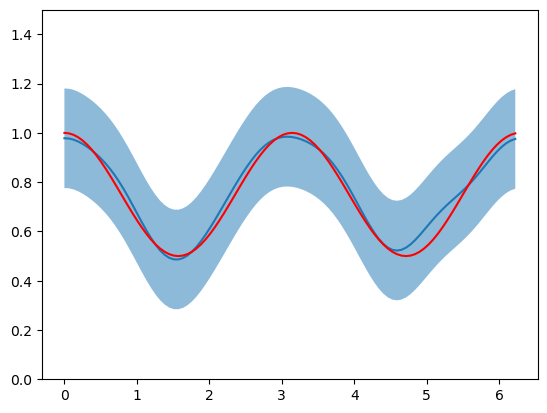

In [28]:
plt.plot(train_theta, observed_y)
plt.plot(train_theta, test_y, color='red')
lower, upper = observed_pred.confidence_region()
plt.fill_between(train_theta.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.ylim(0, 1.5)
plt.show()

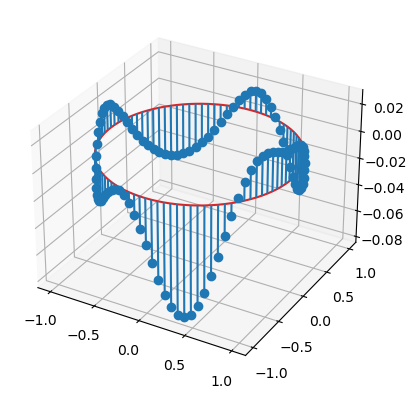

In [29]:
diff_y = test_y - observed_y
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(train_x1.numpy(), train_x2.numpy(), diff_y.numpy())
plt.show()

In [30]:
nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
msll = gpytorch.metrics.mean_standardized_log_loss(observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Standardized Log Loss: {msll:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: -1.3627, 
Mean Standardized Log Loss: -1.3302, 
Mean Squared Error: 0.0009, 
Mean Absolute Error: 0.0234


## Varying Width

In [81]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = PGFKernel(width=[2])
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [82]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.825   noise: 0.693
Iter 2/50 - Loss: 0.790   noise: 0.644
Iter 3/50 - Loss: 0.755   noise: 0.598
Iter 4/50 - Loss: 0.719   noise: 0.554
Iter 5/50 - Loss: 0.684   noise: 0.513
Iter 6/50 - Loss: 0.647   noise: 0.474
Iter 7/50 - Loss: 0.611   noise: 0.437
Iter 8/50 - Loss: 0.574   noise: 0.403
Iter 9/50 - Loss: 0.538   noise: 0.371
Iter 10/50 - Loss: 0.501   noise: 0.340
Iter 11/50 - Loss: 0.464   noise: 0.312
Iter 12/50 - Loss: 0.427   noise: 0.286
Iter 13/50 - Loss: 0.390   noise: 0.262
Iter 14/50 - Loss: 0.353   noise: 0.240
Iter 15/50 - Loss: 0.317   noise: 0.219
Iter 16/50 - Loss: 0.280   noise: 0.200
Iter 17/50 - Loss: 0.244   noise: 0.182
Iter 18/50 - Loss: 0.209   noise: 0.166
Iter 19/50 - Loss: 0.174   noise: 0.151
Iter 20/50 - Loss: 0.141   noise: 0.138
Iter 21/50 - Loss: 0.108   noise: 0.126
Iter 22/50 - Loss: 0.077   noise: 0.115
Iter 23/50 - Loss: 0.047   noise: 0.104
Iter 24/50 - Loss: 0.018   noise: 0.095
Iter 25/50 - Loss: -0.008   noise: 0.087
Iter 26/

In [83]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

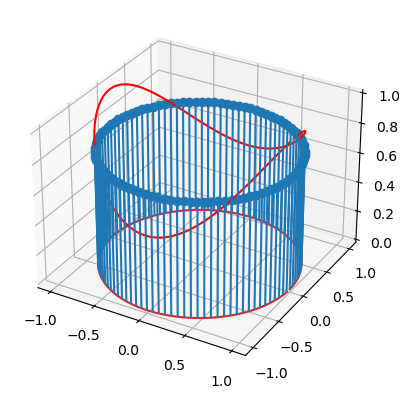

In [84]:
observed_y = observed_pred.mean
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(train_x1.numpy(), train_x2.numpy(), observed_y.numpy())
ax.plot(train_x1.numpy(), train_x2.numpy(), test_y.numpy(), color='red')
plt.show()

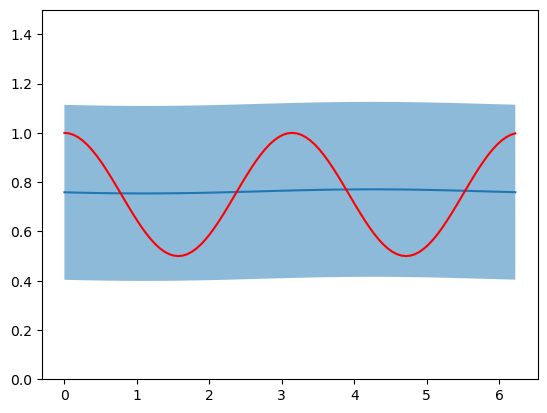

In [85]:
plt.plot(train_theta, observed_y)
plt.plot(train_theta, test_y, color='red')
lower, upper = observed_pred.confidence_region()
plt.fill_between(train_theta.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.ylim(0, 1.5)
plt.show()

In [86]:
nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
msll = gpytorch.metrics.mean_standardized_log_loss(observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Standardized Log Loss: {msll:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: -0.3019, 
Mean Standardized Log Loss: -0.3109, 
Mean Squared Error: 0.0314, 
Mean Absolute Error: 0.1594


In [37]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = PGFKernel(width=[4])
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [38]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.847   noise: 0.693
Iter 2/50 - Loss: 0.811   noise: 0.644
Iter 3/50 - Loss: 0.775   noise: 0.598
Iter 4/50 - Loss: 0.739   noise: 0.554
Iter 5/50 - Loss: 0.702   noise: 0.513
Iter 6/50 - Loss: 0.665   noise: 0.474
Iter 7/50 - Loss: 0.628   noise: 0.437
Iter 8/50 - Loss: 0.590   noise: 0.403
Iter 9/50 - Loss: 0.552   noise: 0.370
Iter 10/50 - Loss: 0.513   noise: 0.340
Iter 11/50 - Loss: 0.474   noise: 0.312
Iter 12/50 - Loss: 0.435   noise: 0.286
Iter 13/50 - Loss: 0.395   noise: 0.262
Iter 14/50 - Loss: 0.354   noise: 0.239
Iter 15/50 - Loss: 0.314   noise: 0.218
Iter 16/50 - Loss: 0.273   noise: 0.199
Iter 17/50 - Loss: 0.231   noise: 0.181
Iter 18/50 - Loss: 0.190   noise: 0.165
Iter 19/50 - Loss: 0.148   noise: 0.150
Iter 20/50 - Loss: 0.106   noise: 0.136
Iter 21/50 - Loss: 0.065   noise: 0.124
Iter 22/50 - Loss: 0.023   noise: 0.112
Iter 23/50 - Loss: -0.019   noise: 0.102
Iter 24/50 - Loss: -0.060   noise: 0.092
Iter 25/50 - Loss: -0.101   noise: 0.084
Iter 2

In [39]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

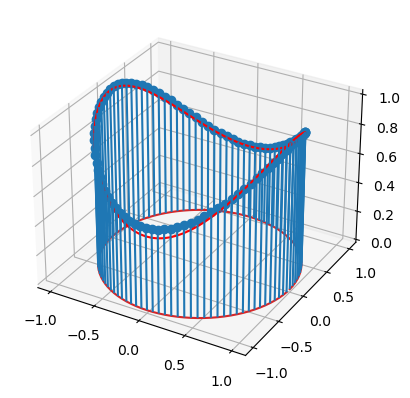

In [40]:
observed_y = observed_pred.mean
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(train_x1.numpy(), train_x2.numpy(), observed_y.numpy())
ax.plot(train_x1.numpy(), train_x2.numpy(), test_y.numpy(), color='red')
plt.show()

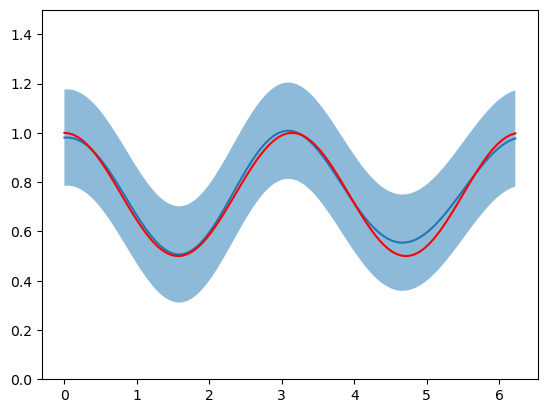

In [41]:
plt.plot(train_theta, observed_y)
plt.plot(train_theta, test_y, color='red')
lower, upper = observed_pred.confidence_region()
plt.fill_between(train_theta.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.ylim(0, 1.5)
plt.show()

In [42]:
nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
msll = gpytorch.metrics.mean_standardized_log_loss(observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Standardized Log Loss: {msll:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: -1.4006, 
Mean Standardized Log Loss: -1.3772, 
Mean Squared Error: 0.0006, 
Mean Absolute Error: 0.0187


## Varying Kernel

### Matérn Kernel

In [43]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [44]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.865   noise: 0.693
Iter 2/50 - Loss: 0.822   noise: 0.644
Iter 3/50 - Loss: 0.779   noise: 0.598
Iter 4/50 - Loss: 0.735   noise: 0.554
Iter 5/50 - Loss: 0.692   noise: 0.513
Iter 6/50 - Loss: 0.649   noise: 0.474
Iter 7/50 - Loss: 0.606   noise: 0.437
Iter 8/50 - Loss: 0.563   noise: 0.403
Iter 9/50 - Loss: 0.520   noise: 0.370
Iter 10/50 - Loss: 0.478   noise: 0.340
Iter 11/50 - Loss: 0.435   noise: 0.312
Iter 12/50 - Loss: 0.392   noise: 0.285
Iter 13/50 - Loss: 0.349   noise: 0.261
Iter 14/50 - Loss: 0.307   noise: 0.239
Iter 15/50 - Loss: 0.264   noise: 0.218
Iter 16/50 - Loss: 0.221   noise: 0.198
Iter 17/50 - Loss: 0.178   noise: 0.181
Iter 18/50 - Loss: 0.135   noise: 0.164
Iter 19/50 - Loss: 0.092   noise: 0.149
Iter 20/50 - Loss: 0.050   noise: 0.136
Iter 21/50 - Loss: 0.008   noise: 0.123
Iter 22/50 - Loss: -0.034   noise: 0.112
Iter 23/50 - Loss: -0.075   noise: 0.101
Iter 24/50 - Loss: -0.115   noise: 0.092
Iter 25/50 - Loss: -0.155   noise: 0.083
Iter 

In [45]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

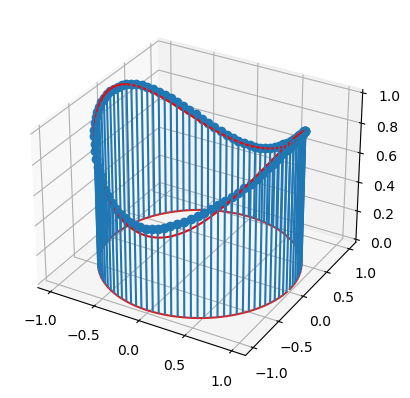

In [46]:
observed_y = observed_pred.mean
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(train_x1.numpy(), train_x2.numpy(), observed_y.numpy())
ax.plot(train_x1.numpy(), train_x2.numpy(), test_y.numpy(), color='red')
plt.show()

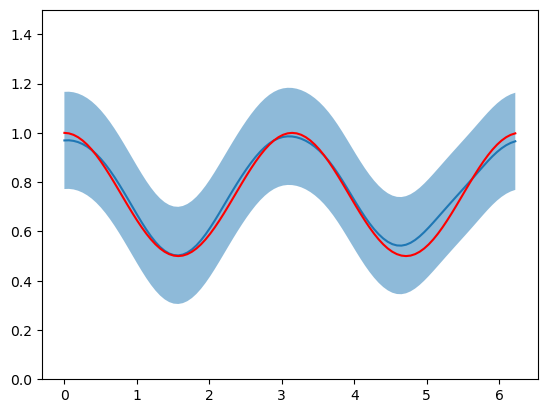

In [47]:
plt.plot(train_theta, observed_y)
plt.plot(train_theta, test_y, color='red')
lower, upper = observed_pred.confidence_region()
plt.fill_between(train_theta.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.ylim(0, 1.5)
plt.show()

In [48]:
nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
msll = gpytorch.metrics.mean_standardized_log_loss(observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Standardized Log Loss: {msll:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: -1.3854, 
Mean Standardized Log Loss: -1.3587, 
Mean Squared Error: 0.0008, 
Mean Absolute Error: 0.0222


### SE Kernel

In [49]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [50]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.850   noise: 0.693
Iter 2/50 - Loss: 0.808   noise: 0.644
Iter 3/50 - Loss: 0.765   noise: 0.598
Iter 4/50 - Loss: 0.722   noise: 0.554
Iter 5/50 - Loss: 0.680   noise: 0.513
Iter 6/50 - Loss: 0.637   noise: 0.474
Iter 7/50 - Loss: 0.595   noise: 0.437
Iter 8/50 - Loss: 0.553   noise: 0.403
Iter 9/50 - Loss: 0.511   noise: 0.370
Iter 10/50 - Loss: 0.470   noise: 0.340
Iter 11/50 - Loss: 0.428   noise: 0.312
Iter 12/50 - Loss: 0.387   noise: 0.286
Iter 13/50 - Loss: 0.345   noise: 0.261
Iter 14/50 - Loss: 0.304   noise: 0.239
Iter 15/50 - Loss: 0.262   noise: 0.218
Iter 16/50 - Loss: 0.221   noise: 0.199
Iter 17/50 - Loss: 0.179   noise: 0.181
Iter 18/50 - Loss: 0.137   noise: 0.165
Iter 19/50 - Loss: 0.096   noise: 0.150
Iter 20/50 - Loss: 0.054   noise: 0.136
Iter 21/50 - Loss: 0.012   noise: 0.124
Iter 22/50 - Loss: -0.029   noise: 0.112
Iter 23/50 - Loss: -0.071   noise: 0.102
Iter 24/50 - Loss: -0.112   noise: 0.092
Iter 25/50 - Loss: -0.154   noise: 0.084
Iter 

In [51]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

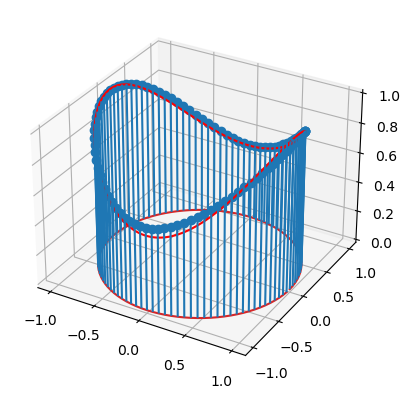

In [52]:
observed_y = observed_pred.mean
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(train_x1.numpy(), train_x2.numpy(), observed_y.numpy())
ax.plot(train_x1.numpy(), train_x2.numpy(), test_y.numpy(), color='red')
plt.show()

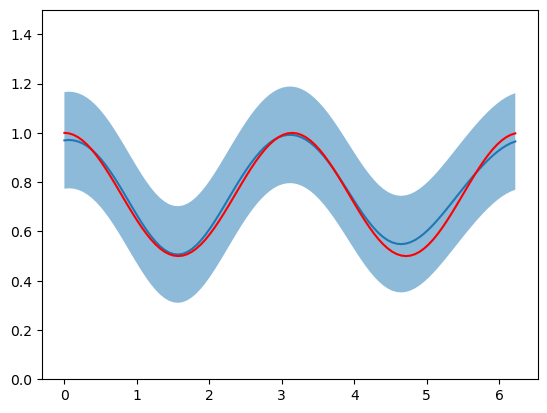

In [53]:
plt.plot(train_theta, observed_y)
plt.plot(train_theta, test_y, color='red')
lower, upper = observed_pred.confidence_region()
plt.fill_between(train_theta.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.ylim(0, 1.5)
plt.show()

In [54]:
nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
msll = gpytorch.metrics.mean_standardized_log_loss(observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Standardized Log Loss: {msll:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: -1.3927, 
Mean Standardized Log Loss: -1.3677, 
Mean Squared Error: 0.0007, 
Mean Absolute Error: 0.0210


In [55]:
se_y = observed_pred.mean

### RQ Kernel

In [56]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [57]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.846   noise: 0.693
Iter 2/50 - Loss: 0.805   noise: 0.644
Iter 3/50 - Loss: 0.763   noise: 0.598
Iter 4/50 - Loss: 0.722   noise: 0.554
Iter 5/50 - Loss: 0.680   noise: 0.513
Iter 6/50 - Loss: 0.638   noise: 0.474
Iter 7/50 - Loss: 0.596   noise: 0.437
Iter 8/50 - Loss: 0.554   noise: 0.403
Iter 9/50 - Loss: 0.513   noise: 0.370
Iter 10/50 - Loss: 0.471   noise: 0.340
Iter 11/50 - Loss: 0.429   noise: 0.312
Iter 12/50 - Loss: 0.387   noise: 0.286
Iter 13/50 - Loss: 0.345   noise: 0.261
Iter 14/50 - Loss: 0.303   noise: 0.239
Iter 15/50 - Loss: 0.261   noise: 0.218
Iter 16/50 - Loss: 0.219   noise: 0.199
Iter 17/50 - Loss: 0.177   noise: 0.181
Iter 18/50 - Loss: 0.135   noise: 0.165
Iter 19/50 - Loss: 0.093   noise: 0.150
Iter 20/50 - Loss: 0.052   noise: 0.136
Iter 21/50 - Loss: 0.011   noise: 0.124
Iter 22/50 - Loss: -0.030   noise: 0.112
Iter 23/50 - Loss: -0.070   noise: 0.102
Iter 24/50 - Loss: -0.109   noise: 0.092
Iter 25/50 - Loss: -0.148   noise: 0.084
Iter 

In [58]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

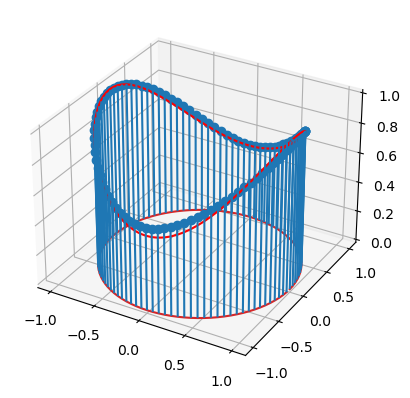

In [59]:
observed_y = observed_pred.mean
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(train_x1.numpy(), train_x2.numpy(), observed_y.numpy())
ax.plot(train_x1.numpy(), train_x2.numpy(), test_y.numpy(), color='red')
plt.show()

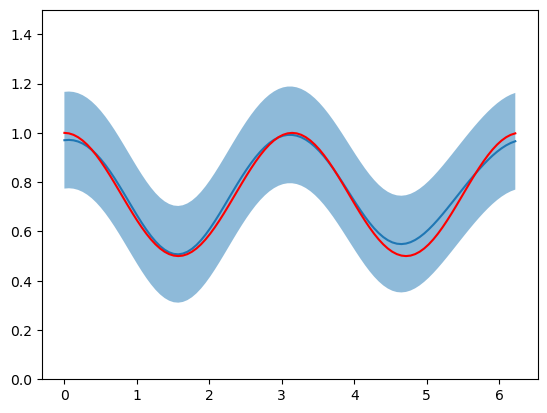

In [60]:
plt.plot(train_theta, observed_y)
plt.plot(train_theta, test_y, color='red')
lower, upper = observed_pred.confidence_region()
plt.fill_between(train_theta.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
plt.ylim(0, 1.5)
plt.show()

In [61]:
nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
msll = gpytorch.metrics.mean_standardized_log_loss(observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Standardized Log Loss: {msll:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: -1.3918, 
Mean Standardized Log Loss: -1.3673, 
Mean Squared Error: 0.0007, 
Mean Absolute Error: 0.0209


# Summary plot

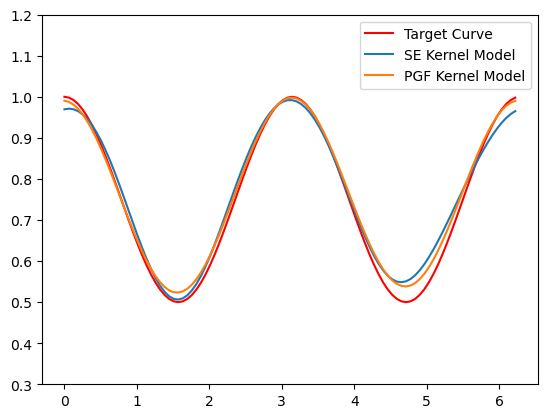

In [62]:
plt.plot(train_theta.numpy(), test_y.numpy(), color='red')
plt.plot(train_theta.numpy(), se_y.numpy())
plt.plot(train_theta.numpy(), pgf_y.numpy())
plt.legend(['Target Curve', 'SE Kernel Model', 'PGF Kernel Model'])
plt.ylim(0.3, 1.2)
plt.show()